In [1]:
import os
import gc
import sys
from os.path import basename
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf

import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, accuracy_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

sys.path.append("../")

from helpers.split import tag_label_feature_split, make_train_test_split
from helpers.assess import make_classification_report, make_confusion_matrix

sns.set_style("darkgrid")
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

DATASET_FOLDER = os.path.join(Path().absolute().parents[0], 'datasets')

c:\Users\alvin\anaconda3\envs\W207_project\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**MTG-Jamendo Dataset**

Our project uses  the MTG-Jamendo dataset.

It is built using music available at Jamendo under Creative Commons licenses and tags provided by content uploaders. The dataset contains over 55,000 full audio tracks with 195 tags from genre, instrument, and mood/theme categories.

As we describe in greater detail in our report, we limit our analysis to songs that are identified as belonging to exactly one of ten genres.  We eliminate songs in other genres.  We also eliminate songs labelled as belonging to more than one genre.

After flattening arrays, the dataset includes 2,654 features excluding mel spectrogram data.  We considered several collections of features, for example, one collection included all features in the dataset other than the mel spectrograms, another version consisted of just the mel spectrogram data.  In addition we looked at nine other combinations of features.

https://mtg.github.io/mtg-jamendo-dataset/

**Exploratory Data Analysis -- Class Imbalance**

The genres within the scope of our project are:

+ blues
+ classical
+ country
+ disco
+ hiphop
+ jazz
+ metal
+ genre_pop
+ reggae
+ rock

As noted above, we removed songs from the dataset that were labelled as being in other genres and we removed songs labelled as belonging to more than one of the genres listed above.

The exploratory data analysis that follows is on the version of the dataset that includes all of the features other than mel spectrograms, which we handle separately.  We refer to this dataset as our **all features** dataset.

In [2]:
# Read the data set

df = pd.read_pickle(os.path.join(DATASET_FOLDER, "dataset_00_all.pickle"))

In [3]:
# Get labels, a label encoder and features using a utility function
# we wrote to separate labels and features from the MTG-Jamendo dataset
# and also to discard extraneous metadata.  The code for this function can
# be found in the helpers folder of the project repository.

_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [4]:
# Review the mapping between genre_ids and the genres themselves.

print(f'id genre\n-- -----')
for id, genre in enumerate(le.inverse_transform(range(10))):
    print (f'{id}  {genre[6:]}')

id genre
-- -----
0  blues
1  classical
2  country
3  disco
4  hiphop
5  jazz
6  metal
7  pop
8  reggae
9  rock


Our data is imbalanced.  The pop, classical and rock genres dominate the dataset.  At the other end of the spectrum, blues, country and disco are under represented.  We see this as an artifact of this particular data set only and not reflective of anything more.  Many of the models we work with provide a parameter that takes into account class imbalance and weights accordingly based on inverse population proportion to enhance the significance of individual data points from under represented classes.  We utitilize that approach when we can.  In some cases, which we describe below, we look to other means to address the imbalance.

In [5]:
pd.DataFrame(le.inverse_transform(y), columns=['genre']).value_counts()

genre          
genre_pop          5343
genre_classical    5276
genre_rock         4000
genre_hiphop       2126
genre_jazz         1552
genre_reggae        985
genre_metal         831
genre_blues         468
genre_country       409
genre_disco         361
dtype: int64

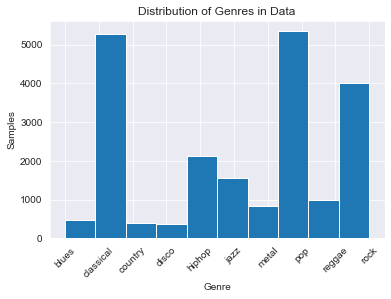

In [6]:
x_labels = [label[6:] for label in le.inverse_transform(range(10))]
plt.hist([y])
plt.title("Distribution of Genres in Data")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.xticks(range(10), x_labels, rotation=45)
plt.show()

As mentioned above, the complete feature set comprises 2,654 features.  We discuss features below.

In [7]:
# review the shapes
print(f"{X.shape= } {y.shape= }")

X.shape= (21351, 2654) y.shape= (21351,)


**Preprocessing**

We set aside 20% of our data for testing and use a stratified split, with shuffling, since we have a multi-class problem. 

In [8]:
# split the data for training and testing with shuffling and stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1962, shuffle=True, stratify=y
)

In [9]:
# review the shapes
print(f"{X_train.shape = }\t{y_train.shape = }")
print(f"{X_test.shape =  }\t{y_test.shape =  }")

X_train.shape = (17080, 2654)	y_train.shape = (17080,)
X_test.shape =  (4271, 2654)	y_test.shape =  (4271,)


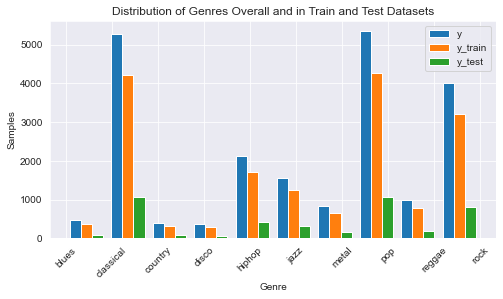

In [10]:
# reconfirm the distribution across the various sets
plt.figure(figsize=(8,4))
plt.hist([y, y_train, y_test],
         label=['y', 'y_train', 'y_test'])
plt.xticks(range(10), x_labels, rotation=45)
plt.title("Distribution of Genres Overall and in Train and Test Datasets")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.legend()
plt.show()

While some models (such as extreme gradient boost) do not require feature scaling or standardization for best performance, most do.  Morever, principal component analysis and some SMOTE-related sampling approaches also benefit from feature scaling or standardization.  Therefore we apply standardization to our feature as a general rule.  

When we work with principal component analysis or SMOTE and SMOTE-related sampling we extended the pre-processing pipeline beyond standardization as the situation warranted.  Our approach to principal component analysis is to use a sufficient number of components to capture 95% of the variance in the underlying data.

As shown below, we are able to capture 95% of the variance in our all features dataset with 387 principal components, a meaningful reduction from the 2,654 components presented in the dataset originally. We will make further use of principal component analysis to visualize our data in the exploratory data analysis included below.

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca=PCA(random_state=1962, n_components=.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [12]:
# review the shapes
print(f"{X_train_scaled.shape = }\t{y_train.shape = }")
print(f"{X_test_scaled.shape  =  }\t {y_test.shape =  }")
print(f"{X_train_pca.shape    = }\t{y_train.shape = }")
print(f"{X_test_pca.shape     =  } \t {y_test.shape =  }")

X_train_scaled.shape = (17080, 2654)	y_train.shape = (17080,)
X_test_scaled.shape  =  (4271, 2654)	 y_test.shape =  (4271,)
X_train_pca.shape    = (17080, 387)	y_train.shape = (17080,)
X_test_pca.shape     =  (4271, 387) 	 y_test.shape =  (4271,)


**Exploratory Data Analysis -- Features**

Machine learning work on audio typically relies on various features extracted from the underlying audio signal.  The signal processing involved is complex and a meaningful discussion is well beyond the scope of this project.

There are a few fundamental concepts that we want to touch on nevertheless.

We begin with spectrograms.  A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.  Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time. See [this article](https://pnsn.org/spectrograms/what-is-a-spectrogram) presented by the Pacific Northwest Seismic Network.  

Studies have shown that humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies. For example, we can easily tell the difference between 500 and 1000 Hz, but we will hardly be able to tell a difference between 10,000 and 10,500 Hz, even though the distance between the two pairs are the same.  In 1937, Stevens, Volkmann, and Newmann proposed a unit of pitch such that equal distances in pitch sounded equally distant to the listener. This is called the mel scale. We perform a mathematical operation on frequencies to convert them to the mel scale.  A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.  See [this article](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53) appearing on medium.com

So, it is most common today to start with the spectrogram representation of an audio signal and convert that to a spectrogram on the mel scale, a mel spectrogram.  Some models, like our CNN model, work directly from the mel spectrogram.  In other cases, people derive useful features from the mel spectrogram.

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.  Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC.They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This very brief summary is based on [this summary](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) appearing on wikipedia.

Many music genre classification models rely to a large degree on MFCCs.  To that end, we paid attention to MFCC data available to us in the dataset.  In particular, the values of thirteen MFCC coefficients, as well as MFCC related variance, covariance and inverse covariance data points presented in the dataset.

We also ran a series of statistical tests to identify features in the dataset that appear to have statistically meaningful relationships to the various genres.  We then ranked their overall statistically meaningfulness by combining their ranking from individual genres. We identified ten features using a p-value driven approach:

![p-value ranking](p_val.png)
  


**Exploratory Data Analysis -- Features -- Principal Component Analysis**

With so many features and classes, we struggled to visualize our data before building our models.  We found that principal component analysis gave us a perspective on the richness and complexity of our data.

The following plot illustrates the ability of PCA to capture information in order to reduce dimensionality.

The plots resuling from the application of PCA to our other dataset variations were not meaningfully different than what we show for our all features dataset.

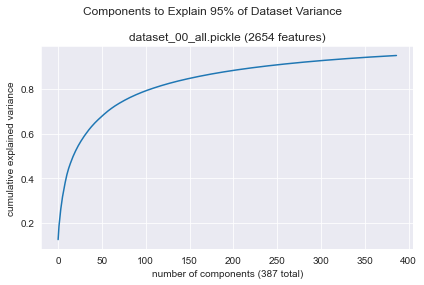

In [13]:
dataset = "../../datasets/dataset_00_all.pickle"
fig, ax = plt.subplots()
fig.suptitle("Components to Explain 95% of Dataset Variance")

original_features = X_train.shape[1]

ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_title(f"{basename(dataset)} ({original_features} features)")
ax.set(
    xlabel=f"number of components ({pca.components_.shape[0]} total)",
    ylabel="cumulative explained variance",
)

plt.tight_layout()
plt.show()
fig.savefig("pca-slide-1.png")

The following two dimensional scatter plot shows our dataset viewed through the lens of just the first two principal components.  While some genres appear to be more readily discernible, others are not.  Separating out this dataset has been challenging and this plot starts to give us a sense of why.

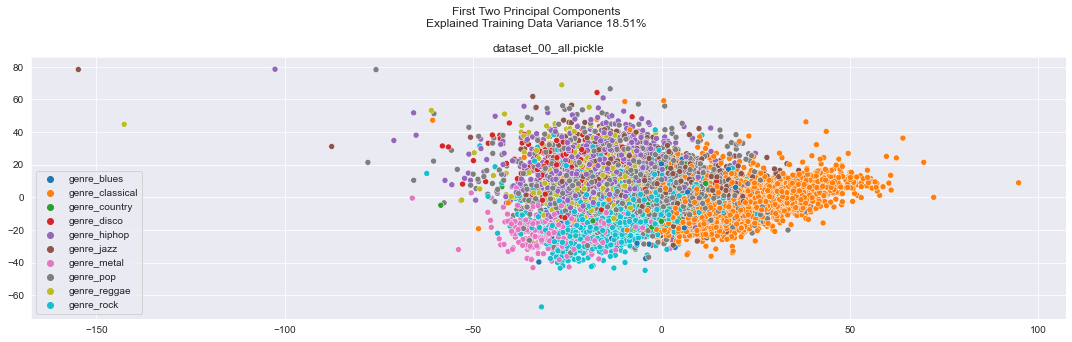

In [14]:
pca_2 = PCA(n_components=2)

# Fit PCA with training features only

X_train_pca_2 = pca_2.fit_transform(X_train_scaled)
X_test_pca_2 = pca_2.transform(X_test_scaled)

# Concatenate test and train data for visualization only

X_pca_2 = np.concatenate((X_train_pca, X_test_pca), axis=0)
y_merged = np.concatenate((y_train, y_test), axis=0)

explanation_ratio = round(sum(pca_2.explained_variance_ratio_[0:2]) * 100, 2)

fig, ax_2d = plt.subplots(figsize=(15, 4.8))
fig.suptitle(
    f"First Two Principal Components\nExplained Training Data Variance {explanation_ratio}%"
)

hue_order = list(le.inverse_transform(range(10)))

sns.scatterplot(
    x=X_pca_2[:, 0],
    y=X_pca_2[:, 1],
    hue=le.inverse_transform(y_merged),
    hue_order=hue_order,
    ax=ax_2d,
    cmap=cmap
).set(title=basename(dataset))


plt.tight_layout()
plt.show()
fig.savefig("pca-slide-2.png")

We wanted to see if adding a third component to the mix might make it easier to separate our classes.  The following three dimensional scatterplot was the result.  Again, this is on our all features dataset.  When we applied this methodology to other renditions of our dataset we did not see anything meaningfully different.  In some cases the data looked reasonably similar to the plot we show below.  In other cases, the data was even more condensed.

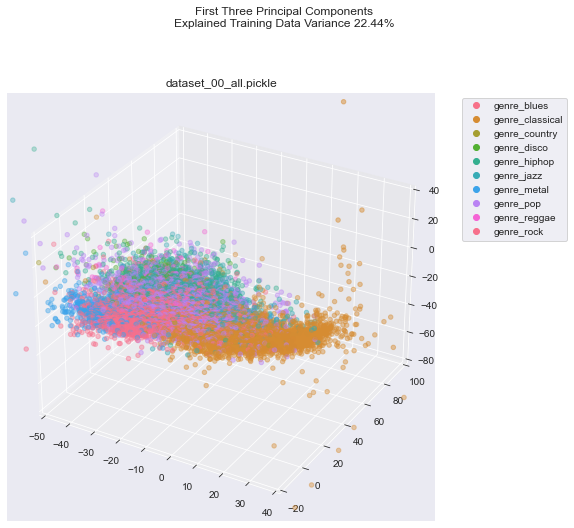

In [15]:
pca_3 = PCA(n_components=3)

# Fit PCA with training features only

X_train_pca_3 = pca_3.fit_transform(X_train_scaled)
X_test_pca_3 = pca_3.transform(X_test_scaled)

# Concatenate test and train data for visualization only

X_pca_3 = np.concatenate((X_train_pca_3, X_test_pca_3), axis=0)
y_merged = np.concatenate((y_train, y_test), axis=0)

explanation_ratio = round(sum(pca_3.explained_variance_ratio_[0:3]) * 100, 2)


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

fig.suptitle(
    f"First Three Principal Components\nExplained Training Data Variance {explanation_ratio}%"
)


pca_3_1 = X_pca_3[:, 0]
pca_3_2 = X_pca_3[:, 1]
pca_3_3 = X_pca_3[:, 2]


scatter = ax.scatter(pca_3_1, pca_3_2, pca_3_3, c=y_merged, cmap=cmap)
plt.legend(
    scatter.legend_elements()[0],
    list(le.inverse_transform(range(10))),
    bbox_to_anchor=(1.05, 1),
    loc=2,
)

ax.set_title(basename(dataset))
ax.set_xlim(-50, 40)
ax.set_ylim(-20, 100)
ax.set_zlim(-80, 40)
plt.tight_layout()
plt.show()
fig.savefig("pca-slide-3.png")

___

**Model Review -- Extreme Gradient Boost**

We built a classifier using Extreme Gradient Boost.

Unlike many models available to us, the Extreme Gradient Boost software we had does not include a way to specify that class imbalance should be handled by supplying class weights.  Weighting is available for binary classifiers but not for imbalanced data sets involving more than two classes.

We began with a default extreme gradient boost model and ran it against our collection of datasets, both with and without principal component analysis as well as various permutations of SMOTE resampling.  While the best results were with our all features dataset, the results were very disappointing in all circumstances.

Eventually, we created a balanced set of data using random undersampling.  With our balanced dataset in hand, the Extreme Gradient Boost models began to perform reasonably well.  Based on our prior work, we decided to use the all features dataset for this purpose.  We note that using principal components did not provide any benefits.

Extreme Gradient Boost has a relatively complex set of hyperparamters.  Using gridsearch to explore the hyperparamter space in a brute force fashion is very inefficient.  So, we turned to a Bayesian Optimization package.

>Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not.  See [https://github.com/fmfn/BayesianOptimization]

The hyerparameters we use in our model result from the use of the Bayesian optimization process.

As we worked to build models we realized that one of the biggest challenges we faced is that the pop genre is difficult to classify (we had a hint of this when looking at the scatterplots shown above).  So, the most heavily represented genre in our dataset turned out to be very hard to classify.

In [16]:
# read a data set
dataset="dataset_00_all.pickle"
df = pd.read_pickle(os.path.join(DATASET_FOLDER, dataset))

In [17]:
# get labels, a label encoder and features
_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [18]:
# undersample to create balanced dataset
rus = RandomUnderSampler(random_state=1962)
X_res, y_res = rus.fit_resample(X, y)

In [19]:
# confirm the number of samples of each class
np.unique(y_res, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([361, 361, 361, 361, 361, 361, 361, 361, 361, 361], dtype=int64))

In [20]:
# split into train/validation and test datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_res, y_res, test_size=0.2, shuffle=True, stratify=y_res, random_state=1962
)

In [21]:
# split training/validation into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=True, stratify=y_train_val, random_state=1962
)

In [22]:
# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [23]:
# build and train the model

classifier = XGBClassifier(
    learning_rate=0.181088,
    n_estimators=419,
    max_depth=3,
    gamma=0.174787,
    reg_alpha=0.4416,
    use_label_encoder=False,
    # tree_method="gpu_hist",  # if running on a machine without a GPU comment out this line
    sampling_method="gradient_based",
    objective="multi:softprob",
    eval_metric=["mlogloss", "auc"], 
    early_stopping_rounds=10,
    seed=1962,
)

eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]
classifier.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

[08:08:02] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['mlogloss', 'auc'],
              gamma=0.174787, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.181088,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=419, n_jobs=24,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=1962, reg_alpha=0.4416, reg_lambda=1,
              sampling_method='gradient_based', scale_pos_weight=None,
              seed=1962, subsample=1, ...)

Lets confirm that our data is now balanced.

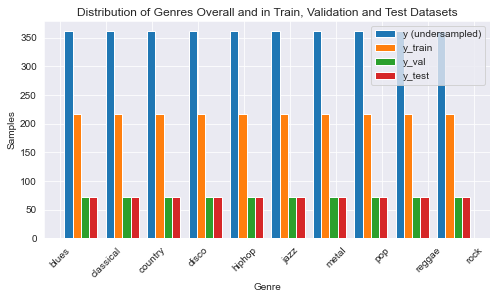

In [24]:
class_count = len(le.classes_)
x_labels = [label[6:] for label in le.inverse_transform(range(class_count))]
plt.figure(figsize=(8,4))
plt.hist([y_res, y_train, y_val, y_test], label=['y (undersampled)', 'y_train', 'y_val', 'y_test'])
plt.xticks(range(class_count), x_labels, rotation=45)
plt.title("Distribution of Genres Overall and in Train, Validation and Test Datasets")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.legend()
plt.show()

Training and Evaluation Curves

In addition to the careful use of hyperparameters, including L1 regularization (L2 did not seem to add meaningful benefit), we use early stopping to keep the classifier from over fitting.

In [25]:
# get training and validation results from the classifier
classifier_results = classifier.evals_result()

train_results=classifier_results['validation_0']
validation_results=classifier_results['validation_1']

In [26]:
# generate predictions on the test dataset
test_predictions=classifier.predict(X_test_scaled)

In [27]:
test_predictions=classifier.predict(X_test_scaled)

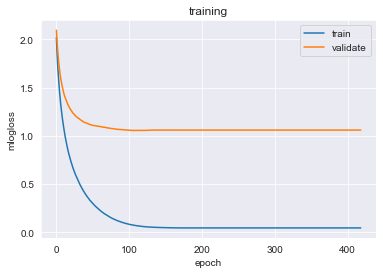

In [28]:
plt.plot(train_results['mlogloss'], label='train')
plt.plot(validation_results['mlogloss'], label='validate')
plt.title('training')
plt.xlabel('epoch')
plt.ylabel('mlogloss')
plt.legend()
plt.show()

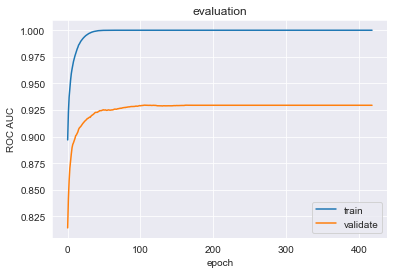

In [29]:
plt.plot(train_results['auc'], label='train')
plt.plot(validation_results['auc'], label='validate')
plt.title('evaluation')
plt.xlabel('epoch')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

Model performance on test data.

As shown below, this model achieves an mcc score of .594 on the test data and a class balanced accuracy of 63.5%.

As evident from the classification report and confusion matrix, each as shown below, the model has very uneven performance across genres.  As mentioned above, the most challenging genres for this model are blues and pop.  On the other hand, the most successful genres are classical and metal.  When we think about the nature of music, those results are not surprising, blues and pop are very wide ranging with a great deal of overlap with other genres.  Classical and metal are more distinctive.  We find rock and jazz somewhere in the middle, each of these are less well defined than classical and metal.

**The results vary with machine, gpu on or not etc -- we may want more general language.  If not, we will need to scrub all discussion of numbers throughout once we finalize.  I have revised the language to be more general for now.  If you agree with this approach, we can make conforming changes for the other models.**

In [30]:
matthews_corrcoef(y_test, test_predictions)

0.5941340789489531

In [31]:
balanced_accuracy_score(y_test, test_predictions)

0.6348173515981734

In [32]:
make_classification_report(y_test, test_predictions, label_encoder=le, print_report=True)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.47    0.44      0.46       72  0.40
  genre_classical       0.79    0.78      0.78       72  0.76
    genre_country       0.75    0.63      0.69       73  0.66
      genre_disco       0.66    0.74      0.70       72  0.66
     genre_hiphop       0.76    0.72      0.74       72  0.72
       genre_jazz       0.58    0.61      0.59       72  0.55
      genre_metal       0.77    0.81      0.79       72  0.77
        genre_pop       0.37    0.30      0.33       73  0.27
     genre_reggae       0.66    0.76      0.71       72  0.68
       genre_rock       0.50    0.56      0.53       72  0.47
                                                             
         accuracy                         0.63      722  0.59
        macro avg       0.63    0.63      0.63      722      
     weighted avg       0.63    0.63      0.63      722      
        

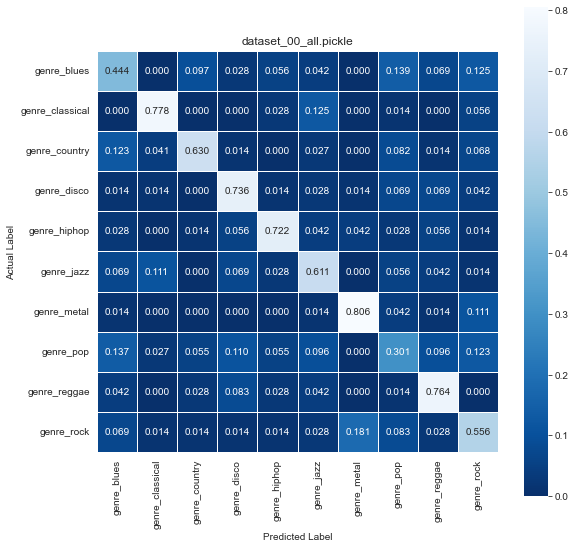

In [33]:
make_confusion_matrix(y_test, test_predictions, label_encoder=le, title=dataset)
pass

Memory control

In [34]:
del df
del dataset
del X
del y
del X_res
del y_res
del X_val
del y_val
del X_train_val
del y_train_val
del scaler
del X_train_scaled
del X_val_scaled
del X_test_scaled
del classifier
del eval_set
del x_labels
del classifier_results
del train_results
del validation_results
del test_predictions

gc.collect()

32664

---

**Model Review -- Convolutional Neural Net**

We also built a Convolutional Neural Net model using the mel spectrogram representation of our dataset.  This dataset consists solely of the mel spectrogram representation of the audio being sampled without any additional feature extraction.

The samples in our dataset do not have a uniform length.  To address that and to manage the size, we exracted a thirty second segment from the middle of each sample.

We began with a simple random CNN model with one Conv2D layer and one MaxPool2D layer. This model performed poorly with accuracy hovering around 20%.  The loss curve was volative and difficult to tune.

The application of CNN to music genre classification is the topic of many research articles. We reviewed relevant literature to help us build our model.  We worked from the model described in [this article](https://towardsdatascience.com/music-genre-recognition-using-convolutional-neural-networks-cnn-part-1-212c6b93da76) to jump start our baseline CNN model. 

Unfortunately, using the center cropped 30s mel spectrogram dataset on the baseline model was not satisfactory. The loss curve suggested that the model need more sample data. By partitioning the center cropped 30 second data into 10 three second chunks, we significantly improved the model's performance. After fine tuning, the model was able to reach a validation accuracy of 56% with the classical genre at about 78%.  This is consistent with the Extreme Gradient Boost model that performed well on that genre. 

Even though the validation loss curve volatility was less than with our first model, it continued to exist at an unsatisfactory level. Moreover, the training loss curve continued to decrease while the validation loss curve hit a plateau. We attribute this to noise in our data and the imbalance in our dataset.

To further address the volatile accuracy and loss curves, we used under sampling to run this model on a balanced dataset (with the pop genre). We suffered a little bit with the overall balanced acuracy but improved in MCC and f1 score. Some genre, however, saw some improvement while genre such as pop remains unsatisfactory. The accuracy and loss curve volatility also improved, meaning future fine tuning will produce a more stable and consistent result than non-balanced dataset. Learning from the previous models, we believe that if we can increase our sample size, the model will improve.

As discussed above, we recognize that what constitutes "pop" music varies over time and that there is significant overlap between the pop music genre and others.  We also note that our imbalanced dataset is dominated by songs in the pop genre.  So, our imbalanced data set is dominated by what appeared to us to be the most difficult genre to classify.

By removing pop from the dataset, we saw a meaningful increase in validation accuracy, reaching 62% overall and the classical music genre reaching 86%.

In [35]:
def split10(array):
    return np.array_split(array[:, 0:680], 10, axis=1)

def partition(df, shuffle=True):
    df['melspec'] = df['melspec'].apply(split10)
    df = df.explode(['melspec']).reset_index(drop=True)
    if shuffle:
        df = df.sample(frac=1) #shuffle
    
    return df

def transformData(X):
    # extract 2D numpy array from pandas dataframe
    X = np.array(list(X.to_numpy()[:,0]))

    scaler = StandardScaler()
    # flatten 2D array to fit to "overall" mean / variance
    scaler.fit(X.reshape(-1,1))
    # must be reshaped for transformation then restored to original shape
    X = scaler.transform(X.reshape(-1, 1)).reshape(X.shape)

    # add a dimension from (n, 96, 68) to (n, 96, 68, 1)
    X = np.expand_dims(X, axis=-1)

    return X

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def same_prepare_process(df, balanced = False):
    df = partition(df)

    _, (y, le), X = tag_label_feature_split(
        df, label_format="encoded"
    )

    if balanced:
        rus = RandomUnderSampler(random_state=1962)
        X, y = rus.fit_resample(X, y)

    X = transformData(X)

    X_train, X_test, y_train, y_test = make_train_test_split(
        X, y, test_size=0.2, random_state=1962, stratify=y
    )

    X_train, X_validation, y_train, y_validation = make_train_test_split(
            X_train, y_train, test_size=0.25, random_state=1962, stratify=y_train
        )

    class_weight={i:c  for i,c in enumerate(compute_class_weight(class_weight='balanced',classes=le.transform(le.classes_),y=y_train))}

    del X
    del y

    gc.collect()

    return X_train, X_test, y_train, y_test, X_validation, y_validation, class_weight, le

def accuracy_and_loss_curve(hist):
    history = hist.history

    # plot loss for train and validation
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history['loss'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_loss'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('Loss')

    ax = fig.add_subplot(1, 3, 2)
    plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_accuracy'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.7,0.8)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('accuracy')

    print('After fine-tuning this model, evaluation on the validation data shows an accuracy of:',
        np.round(history['val_accuracy'][-1]*100,2), '%'
    )

## Unbalanced w/ pop model

In [36]:
# reading dataset
dataset="dataset_10_melspecs.pickle"
df = pd.read_pickle(os.path.join(DATASET_FOLDER, dataset))

In [37]:
# partition each song into 10 chuncks
df = partition(df)

In [38]:
_, (y, le), X = tag_label_feature_split(
    df, label_format="encoded"
)

del df

In [39]:
X = transformData(X)

In [40]:
X_train, X_test, y_train, y_test = make_train_test_split(
        X, y, test_size=0.2, random_state=1962, stratify=y
    )

X_train, X_validation, y_train, y_validation = make_train_test_split(
        X_train, y_train, test_size=0.25, random_state=1962, stratify=y_train
    )

class_weight={i:c  for i,c in enumerate(compute_class_weight(class_weight='balanced',classes=le.transform(le.classes_),y=y_train))}

del X
del y

Lets examine some mel spectrograms for each genre

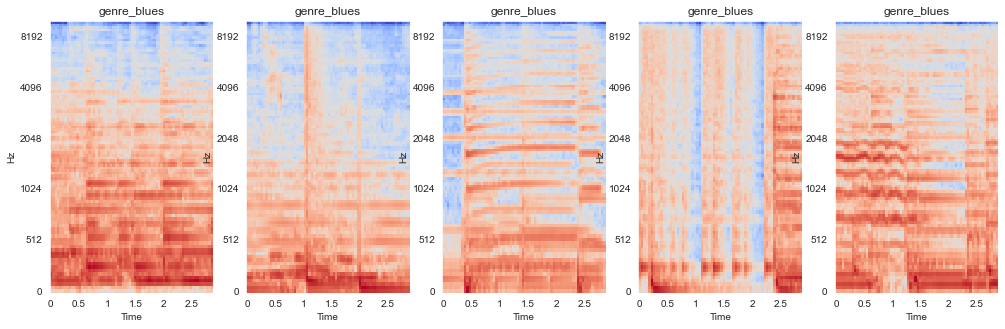

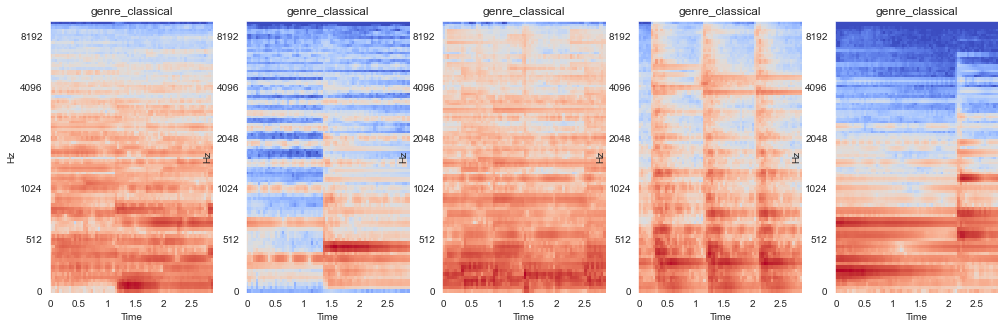

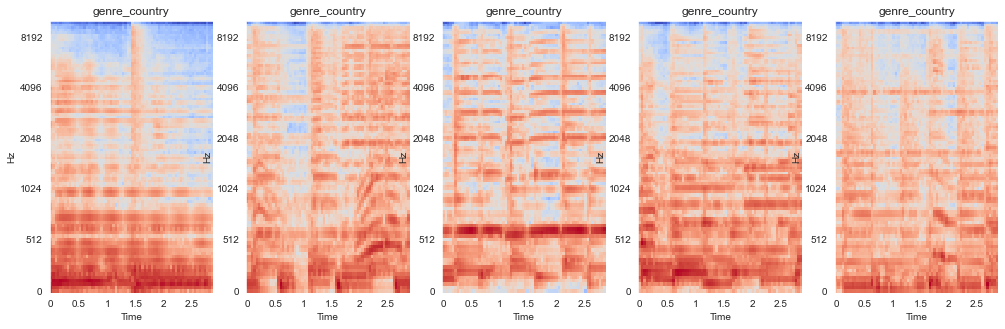

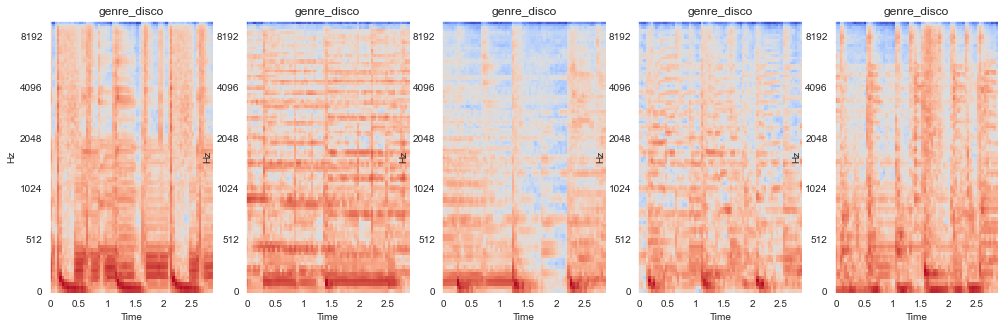

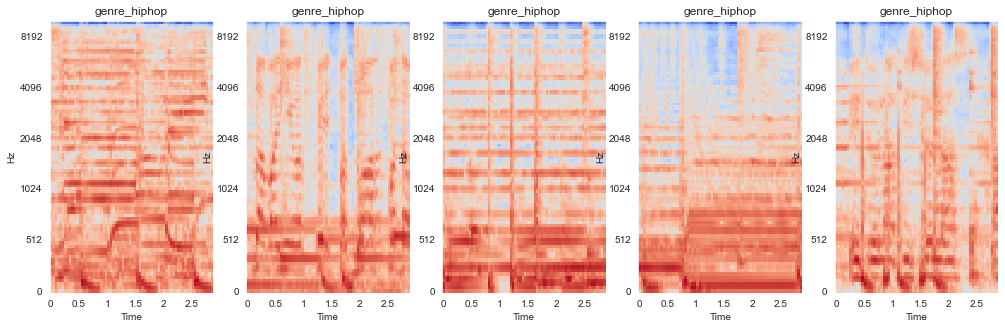

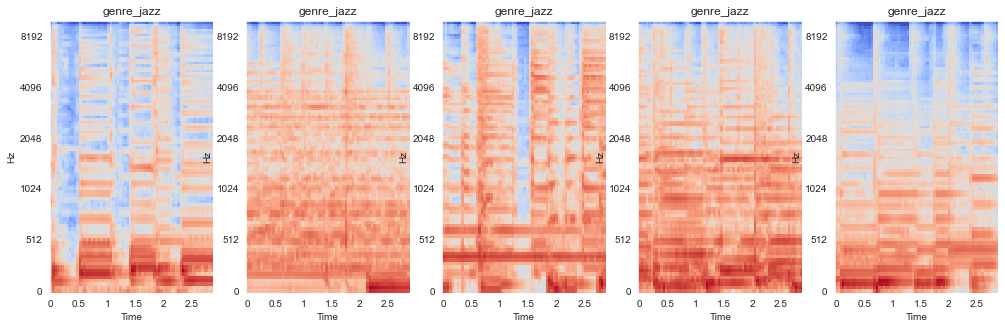

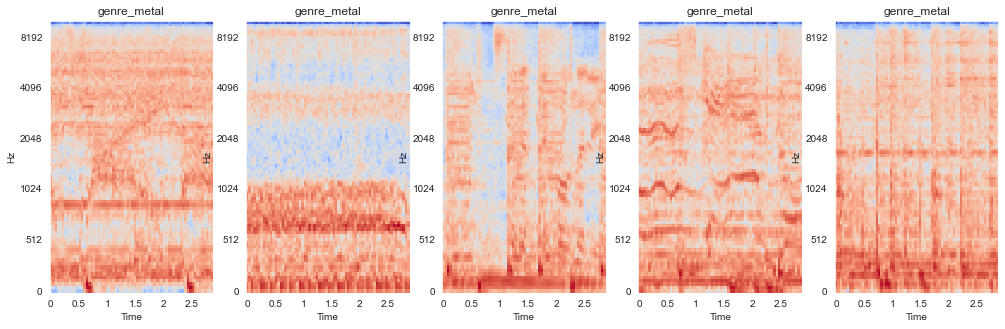

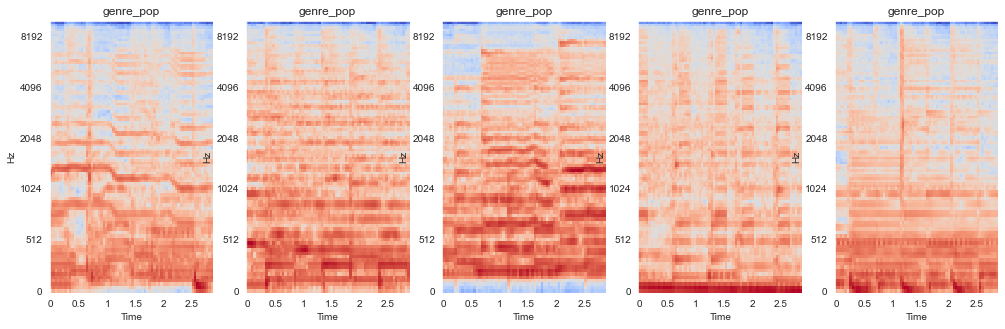

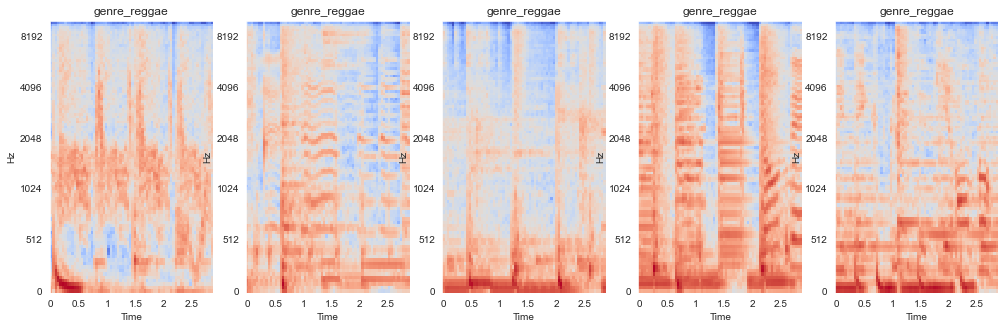

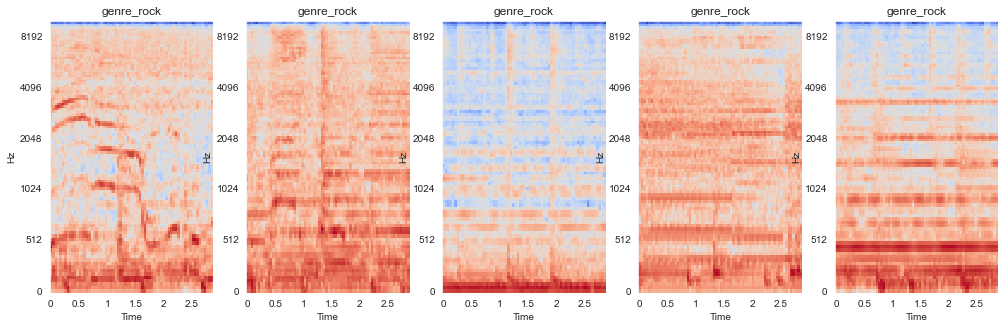

In [41]:
for l in range(10):
    nrows, ncols = 1,5 #print first 4 images
    f, axs = plt.subplots(nrows, ncols, figsize=(17,5))
    tempArr = X_train[y_train == l, :]
    label = le.inverse_transform([l])[0]
    num = 0
    for i in range(ncols):
        img = librosa.display.specshow(np.squeeze(tempArr[num], axis = -1), x_axis='time',
                            y_axis='mel', sr=12000,
                            fmax=10000, ax=axs[i])
        axs[i].set(title=label)
        num += 1
    plt.show()

Lets build the model

In [42]:
def build_model(
    filters=[16, 32, 64, 128],
    kernal_size=[(3,3), (3,3), (3,3), (3,3)],
    strides=(1, 1),
    padding='same',
    activation='relu',
    pool_size=(2,2),
    batch_axis=[3, 3, -1, -1],
    dropout_rate=[0.3, 0.3, 0.3, 0.3],
    input_shape=(None, 96, 68, 1),
    last_activation='softmax',
    genres=10
):
    model = tf.keras.Sequential()

    for i in range(len(filters)):
        model.add(
            tf.keras.layers.Conv2D(
                filters=filters[i],
                kernel_size=kernal_size[i],
                strides=strides,
                padding=padding,
                name=f'conv_{i}',
                activation=activation
            )
        )
        
        tf.keras.layers.BatchNormalization(batch_axis[i])

        model.add(
            tf.keras.layers.MaxPool2D(
                pool_size=pool_size,
                name=f'pool_{i}'
            )
        )

        model.add(
            tf.keras.layers.Dropout(
                rate=dropout_rate[i],
                name=f'dropout_{i}'
            )
        )

    model.add(tf.keras.layers.Flatten()) 

    model.add(
        tf.keras.layers.Dense(
            units=genres,
            name='fc_last',
            activation=last_activation
        )
    )

    tf.random.set_seed(1)
    model.build(input_shape=input_shape)
    print(model.summary())

    return model

In [43]:
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 96, 68, 16)        160       
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 48, 34, 16)        0         
_________________________________________________________________
dropout_0 (Dropout)          (None, 48, 34, 16)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 48, 34, 32)        4640      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 24, 17, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 17, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 17, 64)        1

In [44]:
learning_rate = 0.00055
epoch = 100

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=50000,
    decay_rate=0.96,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', get_f1]
)

In [45]:
tf.random.set_seed(1234)
np.random.seed(1234)
hist = model.fit(
    X_train,
    y_train,
    epochs=epoch, 
    validation_data=(X_validation,y_validation),
    class_weight=class_weight,
    verbose=0
)

Accuracy and Loss Curves

After careful hyper parameter tuning in general, we found that neither L1 or L2 regularization did not help with overfitting. Smaller learning rates helped.

After fine-tuning this model, evaluation on the validation data shows an accuracy of: 47.58 %


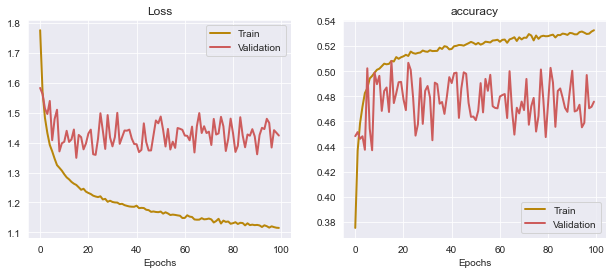

In [46]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss')

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)
ax.set_xlabel('Epochs', size=10)
ax.set_title('accuracy')

print('After fine-tuning this model, evaluation on the validation data shows an accuracy of:',
      np.round(history['val_accuracy'][-1]*100,2), '%'
)

In [47]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [48]:
balanced_accuracy_score(y_test, y_pred)

0.5646887013941724

In [49]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x = X_test,
    label_encoder=le,
    print_report=True
)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.10    0.45      0.17      936  0.18
  genre_classical       0.77    0.85      0.81    10552  0.74
    genre_country       0.15    0.72      0.25      818  0.31
      genre_disco       0.13    0.85      0.22      722  0.31
     genre_hiphop       0.74    0.51      0.60     4252  0.58
       genre_jazz       0.49    0.47      0.48     3104  0.44
      genre_metal       0.30    0.79      0.44     1662  0.46
        genre_pop       0.61    0.13      0.21    10686  0.19
     genre_reggae       0.53    0.59      0.56     1970  0.53
       genre_rock       0.65    0.29      0.40     8000  0.36
                                                             
         accuracy                         0.48    42702  0.42
        macro avg       0.45    0.56      0.41    42702      
     weighted avg       0.62    0.48      0.48    42702      
        

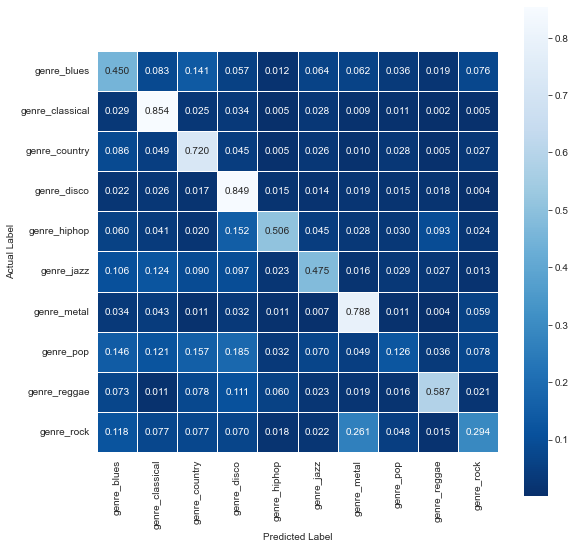

In [50]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x = X_test,
    normalize="true",  
    autoweight_sample=True,  
    label_encoder=le,  
    figsize=(9, 9),  
)
pass

Balanced Accuracy: 0.56 \
MCC: 0.42 \
Macro Average f1: 0.41

## Balanced w/ pop model

In [51]:
df = pd.read_pickle(os.path.join(DATASET_FOLDER, dataset))

In [52]:
X_train, X_test, y_train, y_test, X_validation, y_validation, class_weight, le = same_prepare_process(df, balanced = True)

In [53]:
model = build_model(genres=10)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', get_f1]
)
hist = model.fit(
    X_train,
    y_train,
    epochs=epoch, 
    validation_data=(X_validation,y_validation),
    class_weight=class_weight,
    verbose=0
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 96, 68, 16)        160       
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 48, 34, 16)        0         
_________________________________________________________________
dropout_0 (Dropout)          (None, 48, 34, 16)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 48, 34, 32)        4640      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 24, 17, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 17, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 17, 64)       

Lets examine the accuracy and loss curve again

After fine-tuning this model, evaluation on the validation data shows an accuracy of: 54.7 %


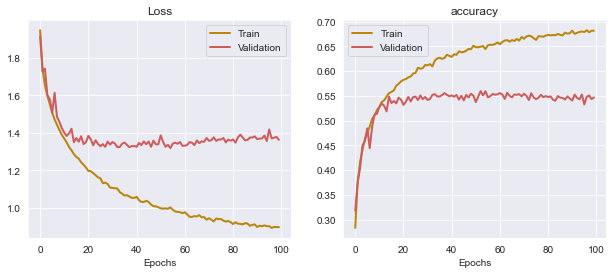

In [54]:
accuracy_and_loss_curve(hist)

In [55]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [56]:
balanced_accuracy_score(y_test, y_pred)

0.5466759002770083

In [57]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x = X_test,
    label_encoder=le,
    print_report=True
)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.42    0.34      0.37      722  0.31
  genre_classical       0.60    0.85      0.71      722  0.68
    genre_country       0.60    0.66      0.63      722  0.58
      genre_disco       0.61    0.75      0.67      722  0.63
     genre_hiphop       0.62    0.53      0.57      722  0.53
       genre_jazz       0.53    0.50      0.52      722  0.47
      genre_metal       0.66    0.75      0.70      722  0.66
        genre_pop       0.23    0.18      0.20      722  0.13
     genre_reggae       0.68    0.56      0.61      722  0.58
       genre_rock       0.39    0.36      0.37      722  0.31
                                                             
         accuracy                         0.55     7220  0.50
        macro avg       0.53    0.55      0.54     7220      
     weighted avg       0.53    0.55      0.54     7220      
        

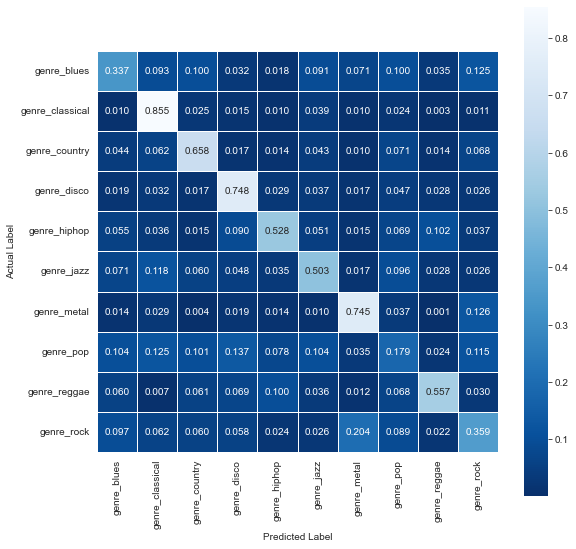

In [58]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x = X_test,
    normalize="true",  
    autoweight_sample=True,  
    label_encoder=le,  
    figsize=(9, 9),  
)
pass

Balanced Accuracy: 0.54 \
MCC: 0.50 \
Macro Average f1: 0.54

Looking at the balanced model, we can see that even though the curve are less volatile, which sugeests that given a larger dataset, we should be able to further fine tune the model and have better performance.

## Balanced w/o pop model

In [59]:
# reading dataset
dataset="dataset_10_melspecs_no_pop.pickle"
df = pd.read_pickle(os.path.join(DATASET_FOLDER, dataset))

In [60]:
print(df.columns)

Index(['melspec', 'genre_blues', 'genre_classical', 'genre_country',
       'genre_disco', 'genre_hiphop', 'genre_jazz', 'genre_metal',
       'genre_reggae', 'genre_rock'],
      dtype='object')


In [61]:
X_train, X_test, y_train, y_test, X_validation, y_validation, class_weight, le = same_prepare_process(df, balanced = True)

In [62]:
model = build_model(genres=9)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', get_f1]
)
hist = model.fit(
    X_train,
    y_train,
    epochs=epoch, 
    validation_data=(X_validation,y_validation),
    class_weight=class_weight,
    verbose=0
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 96, 68, 16)        160       
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 48, 34, 16)        0         
_________________________________________________________________
dropout_0 (Dropout)          (None, 48, 34, 16)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 48, 34, 32)        4640      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 24, 17, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 17, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 17, 64)       

Lets examine the accuracy and loss curve again

After fine-tuning this model, evaluation on the validation data shows an accuracy of: 61.31 %


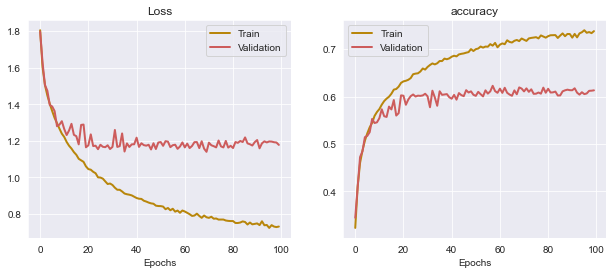

In [63]:
accuracy_and_loss_curve(hist)

In [64]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [65]:
balanced_accuracy_score(y_test, y_pred)

0.6106494305940289

In [66]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x = X_test,
    label_encoder=le,
    print_report=True
)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.42    0.33      0.37      722  0.30
  genre_classical       0.65    0.84      0.73      722  0.70
    genre_country       0.60    0.71      0.65      722  0.60
      genre_disco       0.64    0.80      0.71      722  0.68
     genre_hiphop       0.68    0.60      0.64      722  0.59
       genre_jazz       0.59    0.54      0.56      722  0.51
      genre_metal       0.69    0.72      0.71      722  0.67
     genre_reggae       0.69    0.59      0.64      722  0.60
       genre_rock       0.46    0.38      0.42      722  0.35
                                                             
         accuracy                         0.61     6498  0.56
        macro avg       0.60    0.61      0.60     6498      
     weighted avg       0.60    0.61      0.60     6498      
              min       0.42    0.33      0.37      722  0.30


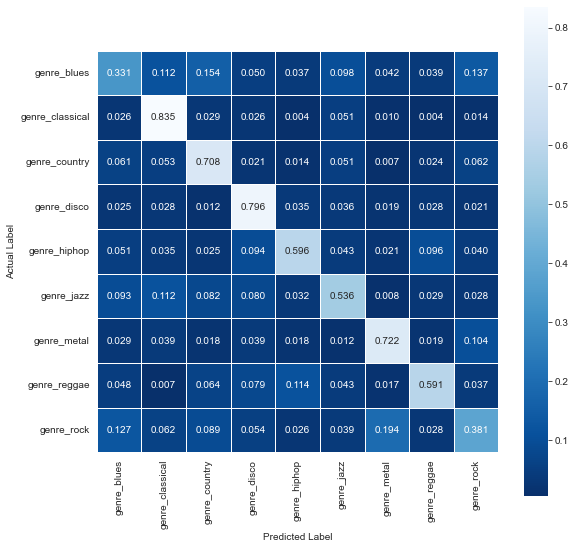

In [67]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x = X_test,
    normalize="true",  
    autoweight_sample=True,  
    label_encoder=le,  
    figsize=(9, 9),  
)
pass

Balanced Accuracy: 0.61 \
MCC: 0.56 \
Macro Average f1: 0.60

Memory control

In [68]:
del df
del dataset
del X_validation
del y_validation
del model
del lr_schedule
del hist
del history
del y_pred

gc.collect()

64195

---